# <center style="color: #FF5A60"> Unveiling the Shifting Landscape of Airbnb:<br>Understanding Supply, Demand, and Pricing Dynamics </center> <a class='tocSkip'>
    
This notebook is dedicated for the details of the `pandas-on-spark` queries that serves as a supplementary to the main report of this project.
    
**! Note:** Rerunning this whole notebook, especially the cells under the `Query Generation` section, is not advisable as this would (1) overwrite the current files generated, and (2) take almost 2 days to finish.

In [113]:
import warnings
warnings.filterwarnings("ignore")
import pyspark.pandas as ps
from pyspark.sql import SparkSession

In [307]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import io

%matplotlib inline

# set global plotting parameters
custom_sns_params = {'lines.linewidth': 1.5, 'font.size': 12,
                     'axes.titlesize': 14, 'axes.labelsize': 12,
                     'xtick.labelsize': 10, 'ytick.labelsize': 10,
                     'legend.fontsize': 12, 'legend.fancybox': True}
sns.set_theme('notebook', style='ticks', rc=custom_sns_params)
colors = ["#e63946", "#1d3557"]
custom_palette = sns.blend_palette(colors, n_colors=5) # 
sns.set_palette(custom_palette)

In [115]:
spark = (SparkSession
         .builder
         .master('local[*]')
         .config('spark.sql.execution.arrow.pyspark.enabled', 'true')
         .getOrCreate())
spark.sparkContext.setLogLevel('OFF')

# I. Background

The analysis looks at the availability and pricing of listings in Airbnb from 2019-2021 across 10 countries namely: France, Italy, Spain, United Kingdom, United States, Belgium, South Africa, Ireland, Switzerland, and Japan. These information are found in their database's **calendar dataset**.


**Challenges**

1. The dataset consists of a substantial `7.9 billion rows`, and executing queries on the main notebook is expected to require a significant amount of time.
2. It took a total of 3.5 hours to load the data into a single dataframe.
3. The additional data cleaning steps, including `missing value imputation` using `median imputation`, required a total of 3.75 hours to complete.
4. The execution time for the queries can vary, ranging from as short as 6 minutes to as long as 1.5 hours.

**Solution**

1. To optimize efficiency, the query results are saved as a data aggregate, allowing for subsequent plotting operations to be performed directly on the saved data.

# II. Data Loading

The data was loaded and processed separately by year before being aggregated by combining the datasets into a single comprehensive dataset. This unified dataset serves as the foundation for running queries and extracting valuable insights.

In [142]:
file = '/mnt/processed/private/msds2023/cpt1/airbnb_data/calendar/2019/*'
df_calendar_2019 = ps.read_parquet(file)
df_calendar_2019

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,year,month,dayofweek,country
0,87732,2019-10-16,f,105.0,105.0,4.0,730.0,2019,October,Wednesday,France
1,3109,2019-10-16,f,60.0,60.0,2.0,30.0,2019,October,Wednesday,France
2,3109,2019-10-17,f,60.0,60.0,2.0,30.0,2019,October,Thursday,France
3,3109,2019-10-18,f,60.0,60.0,2.0,30.0,2019,October,Friday,France
4,3109,2019-10-19,f,60.0,60.0,2.0,30.0,2019,October,Saturday,France
5,3109,2019-10-20,f,60.0,60.0,2.0,30.0,2019,October,Sunday,France
6,3109,2019-10-21,f,60.0,60.0,2.0,30.0,2019,October,Monday,France
7,3109,2019-10-22,f,60.0,60.0,2.0,30.0,2019,October,Tuesday,France
8,3109,2019-10-23,f,60.0,60.0,2.0,30.0,2019,October,Wednesday,France
9,3109,2019-10-24,t,60.0,60.0,2.0,30.0,2019,October,Thursday,France


In [143]:
file = '/mnt/processed/private/msds2023/cpt1/airbnb_data/calendar/2020/*'
df_calendar_2020 = ps.read_parquet(file)
df_calendar_2020

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,year,month,dayofweek,country
0,470132,2020-02-18,f,83.0,75.0,3.0,1125.0,2020,February,Tuesday,Spain
1,470132,2020-02-19,f,83.0,75.0,3.0,1125.0,2020,February,Wednesday,Spain
2,211444,2020-02-18,f,55.0,55.0,2.0,365.0,2020,February,Tuesday,Spain
3,211444,2020-02-19,f,55.0,55.0,2.0,365.0,2020,February,Wednesday,Spain
4,211444,2020-02-20,f,55.0,55.0,2.0,365.0,2020,February,Thursday,Spain
5,211444,2020-02-21,f,55.0,55.0,2.0,365.0,2020,February,Friday,Spain
6,211444,2020-02-22,f,55.0,55.0,2.0,365.0,2020,February,Saturday,Spain
7,211444,2020-02-23,f,55.0,55.0,2.0,365.0,2020,February,Sunday,Spain
8,211444,2020-02-24,f,55.0,55.0,2.0,365.0,2020,February,Monday,Spain
9,211444,2020-02-25,f,55.0,55.0,2.0,365.0,2020,February,Tuesday,Spain


In [144]:
file = '/mnt/processed/private/msds2023/cpt1/airbnb_data/calendar/2021/*'
df_calendar_2021 = ps.read_parquet(file)
df_calendar_2021

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,year,month,dayofweek,country
0,32082,2021-01-13,f,170.0,170.0,3.0,60.0,2021,January,Wednesday,France
1,2577,2021-01-12,t,125.0,125.0,3.0,1125.0,2021,January,Tuesday,France
2,2577,2021-01-13,t,125.0,125.0,3.0,1125.0,2021,January,Wednesday,France
3,2577,2021-01-14,t,125.0,125.0,3.0,1125.0,2021,January,Thursday,France
4,2577,2021-01-15,t,125.0,125.0,3.0,1125.0,2021,January,Friday,France
5,2577,2021-01-16,t,125.0,125.0,3.0,1125.0,2021,January,Saturday,France
6,2577,2021-01-17,t,125.0,125.0,3.0,1125.0,2021,January,Sunday,France
7,2577,2021-01-18,t,125.0,125.0,3.0,1125.0,2021,January,Monday,France
8,2577,2021-01-19,t,125.0,125.0,3.0,1125.0,2021,January,Tuesday,France
9,2577,2021-01-20,t,125.0,125.0,3.0,1125.0,2021,January,Wednesday,France


In [146]:
frames = [df_calendar_2019, df_calendar_2020, df_calendar_2021]

df_calendar = ps.concat(frames)
df_calendar

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,year,month,dayofweek,country
0,87732,2019-10-16,f,105.0,105.0,4.0,730.0,2019,October,Wednesday,France
1,3109,2019-10-16,f,60.0,60.0,2.0,30.0,2019,October,Wednesday,France
2,3109,2019-10-17,f,60.0,60.0,2.0,30.0,2019,October,Thursday,France
3,3109,2019-10-18,f,60.0,60.0,2.0,30.0,2019,October,Friday,France
4,3109,2019-10-19,f,60.0,60.0,2.0,30.0,2019,October,Saturday,France
5,3109,2019-10-20,f,60.0,60.0,2.0,30.0,2019,October,Sunday,France
6,3109,2019-10-21,f,60.0,60.0,2.0,30.0,2019,October,Monday,France
7,3109,2019-10-22,f,60.0,60.0,2.0,30.0,2019,October,Tuesday,France
8,3109,2019-10-23,f,60.0,60.0,2.0,30.0,2019,October,Wednesday,France
9,3109,2019-10-24,t,60.0,60.0,2.0,30.0,2019,October,Thursday,France


# III. Query Generation

## Data Quality

This section focuses on the queries utilized to assess data quality and address any encountered data quality issues throughout the process. It encompasses checking for (1) missing values, (2) handling null values, and (3) conducting subsequent checks to ensure that the data is prepared for analysis.

In [148]:
plot_file = 'mnt/processed/private/msds2023/cpt1/airbnb_data/plots/'
na_df = df_calendar.isna().sum()
null_df = (na_df.drop((na_df.loc[na_df == 0].index).tolist())
                .sort_values(ascending=False)
                .reset_index()
                .rename(columns={'index': 'Columns', None:'Missing Values'}))
null_df.to_csv('plots/null_df', index=False)

,Columns,Missing Values
0,price,338017331
1,adjusted_price,337374001
2,minimum_nights,572931
3,maximum_nights,572931


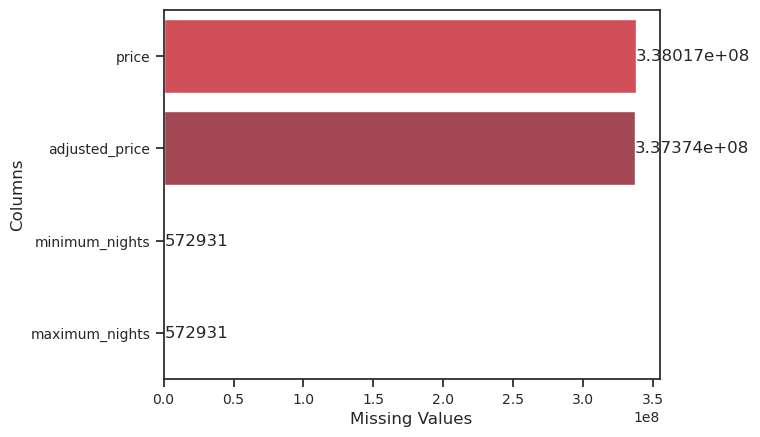

In [308]:
null_df = ps.read_csv('plots/null_df').to_pandas()
ax = sns.barplot(data=null_df, x='Missing Values', y='Columns')

for i in ax.containers:
    ax.bar_label(i,)

To tackle this problem, we will perform `missing value imputation` through `median imputation`. This is because median imputation is a more robust method to handle outliers than `mean imputation`, as it is not influenced by extreme values.

In [243]:
df_calendar = df_calendar.assign(maximum_nights=(df_calendar['maximum_nights']
                                   .fillna(df_calendar['maximum_nights']
                                           .median())),
                                 minimum_nights=(df_calendar['minimum_nights']
                                   .fillna(df_calendar['minimum_nights']
                                           .median())),
                                 adjusted_price=(df_calendar['adjusted_price']
                                   .fillna(df_calendar['adjusted_price']
                                           .median())),
                                 price=(df_calendar['price']
                                   .fillna(df_calendar['price']
                                   .median()))
                                )
df_calendar

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,year,month,dayofweek,country
0,87732,2019-10-16,f,105.0,105.0,4.0,730.0,2019,October,Wednesday,France
1,3109,2019-10-16,f,60.0,60.0,2.0,30.0,2019,October,Wednesday,France
2,3109,2019-10-17,f,60.0,60.0,2.0,30.0,2019,October,Thursday,France
3,3109,2019-10-18,f,60.0,60.0,2.0,30.0,2019,October,Friday,France
4,3109,2019-10-19,f,60.0,60.0,2.0,30.0,2019,October,Saturday,France
5,3109,2019-10-20,f,60.0,60.0,2.0,30.0,2019,October,Sunday,France
6,3109,2019-10-21,f,60.0,60.0,2.0,30.0,2019,October,Monday,France
7,3109,2019-10-22,f,60.0,60.0,2.0,30.0,2019,October,Tuesday,France
8,3109,2019-10-23,f,60.0,60.0,2.0,30.0,2019,October,Wednesday,France
9,3109,2019-10-24,t,60.0,60.0,2.0,30.0,2019,October,Thursday,France


To demonstrate that we have successfully resolved the issue, we will visualize the missing values per column. If there are no more missing values, we should expect a blank plot.

In [244]:
na_df = df_calendar.isna().sum()
null_df_cleaned = (na_df.sort_values(ascending=False)
                        .reset_index()
                        .rename(columns={'index': 'Columns', None:'Missing Values'})
                  )
null_df_cleaned.to_csv('plots/null_df_cleaned', index=False)

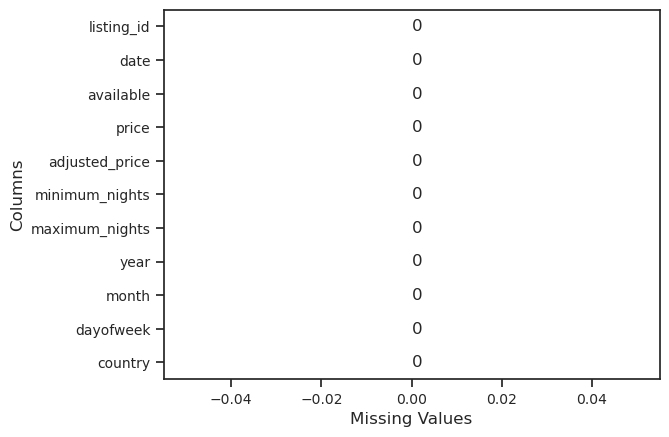

In [309]:
null_df_cleaned = ps.read_csv('plots/null_df_cleaned').to_pandas()

ax = sns.barplot(data=null_df_cleaned, x='Missing Values', y='Columns')

for i in ax.containers:
    ax.bar_label(i,)

# null_df_cleaned.plot.bar(x='Missing Values', y='Columns')

To maintain data integrity, we need to verify if all columns are in the correct datatypes, which should adhere to the following:

- `listing_id`: integer
- `date`: datetime
- `available`: string
- `price`: float
- `adjusted_price`: float
- `minimum_nights`: float
- `maximum_nights`: float
- `year`: integer
- `month`: string
- `dayofweek`: string

In [246]:
buf = io.StringIO()
df_calendar.info(buf=buf)
s = buf.getvalue()
lines = [line.split() for line in s.splitlines()[3:-2]]

df_info = ps.DataFrame(data=lines[2:], columns=lines[0])
df_info.to_csv('plots/infoframe', index=False)

,#,Column,Non-Null,Count,Dtype
0,0,listing_id,7914999048,non-null,int32
1,1,date,7914999048,non-null,datetime64[ns]
2,2,available,7914999048,non-null,object
3,3,price,7914999048,non-null,float64
4,4,adjusted_price,7914999048,non-null,float64
5,5,minimum_nights,7914999048,non-null,float64
6,6,maximum_nights,7914999048,non-null,float64
7,7,year,7914999048,non-null,int32
8,8,month,7914999048,non-null,object
9,9,dayofweek,7914999048,non-null,object


In [310]:
df_info = ps.read_csv('plots/infoframe').to_pandas()
df_info

,#,Column,Non-Null,Count,Dtype
0,3,price,7914999048,non-null,float64
1,4,adjusted_price,7914999048,non-null,float64
2,5,minimum_nights,7914999048,non-null,float64
3,0,listing_id,7914999048,non-null,int32
4,1,date,7914999048,non-null,datetime64[ns]
5,2,available,7914999048,non-null,object
6,6,maximum_nights,7914999048,non-null,float64
7,7,year,7914999048,non-null,int32
8,8,month,7914999048,non-null,object
9,9,dayofweek,7914999048,non-null,object


In [288]:
data_shape = df_calendar.shape
df_shape = ps.DataFrame(data={'Rows': [data_shape[0]],
                              'Columns': [data_shape[1]]},
                              index=['Data Shape'])
df_shape.to_csv('plots/shapeframe', index=False)

In [311]:
df_info = ps.read_csv('plots/shapeframe').to_pandas()
df_info

,Rows,Columns
0,7914999048,11


## Global Temporal Trends Analysis

This section emphasizes the queries performed to derive insights from the cleaned data. The proponents of this study formulated specific questions to guide the query creation process, and the answers to these questions are presented in the main notebook. It is important to note that this notebook serves as a rough sketch of the query generation process.

### 1. How did the prices change over the years? Is there a notable change due to external factors such as the pandemic?

In [248]:
df_quest_1 = (df_calendar.groupby('year')
                         .mean()
                         .reset_index())
df_quest_1.to_csv('plots/df_quest_1', index=False)

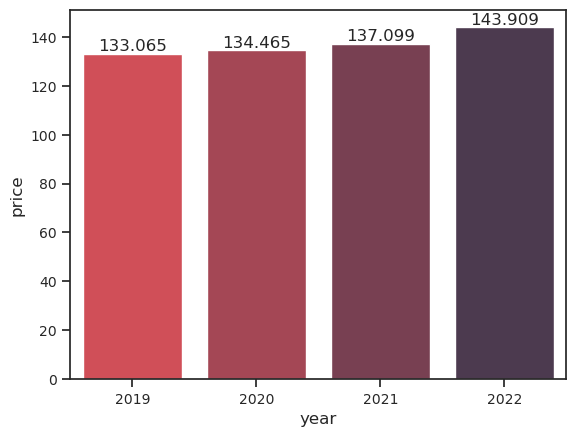

In [312]:
df_quest_1 = ps.read_csv('plots/df_quest_1').to_pandas()

ax = sns.barplot(data=df_quest_1, x='year', y='price')

for i in ax.containers:
    ax.bar_label(i,)


### 2. How did the supply of listings change over the years?

In [250]:

df_quest_2 = (df_calendar.rename(columns={'listing_id': 'listings'})
                         .groupby('year')
                         .mean()
                         .reset_index())
df_quest_2.to_csv('plots/df_quest_2', index=False)

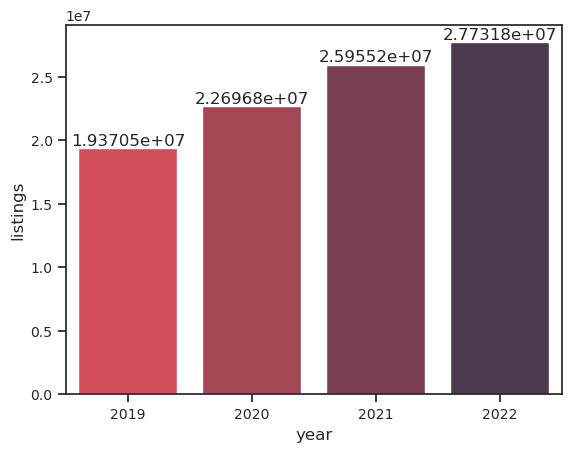

In [313]:
df_quest_2 = ps.read_csv('plots/df_quest_2').to_pandas()

ax = sns.barplot(data=df_quest_2, x='year', y='listings')

for i in ax.containers:
    ax.bar_label(i,)


### 3. How did the demand for airbnb change over the years?

In [252]:
df_quest_3 = (df_calendar.assign(demand=1/data_shape[0])
                         .loc[df_calendar['available'] == 'f']
                         .groupby('year')
                         .sum()
                         .reset_index())

df_quest_3.to_csv('plots/df_quest_3', index=False)

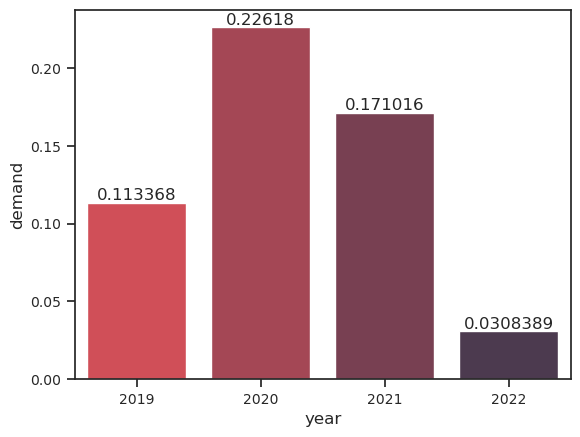

In [314]:
df_quest_3 = ps.read_csv('plots/df_quest_3').to_pandas()

ax = sns.barplot(data=df_quest_3, x='year', y='demand')

for i in ax.containers:
    ax.bar_label(i,)


### 4. How does the price differ for short- vs. long-term stays?

In [254]:
df_quest_4 = (df_calendar.assign(term=df_calendar['minimum_nights'] <= 7)
                         .groupby('term')
                         .mean()
                         .rename(index={True:'Short', False: 'Long'})
                         .reset_index())

df_quest_4.to_csv('plots/df_quest_4', index=False)

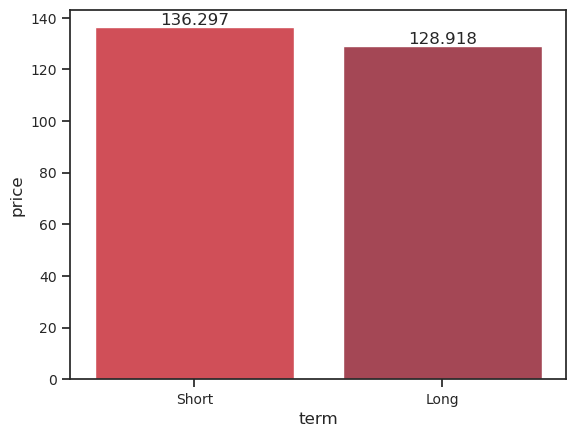

In [315]:
df_quest_4 = ps.read_csv('plots/df_quest_4').to_pandas()

ax = sns.barplot(data=df_quest_4, x='term', y='price')

for i in ax.containers:
    ax.bar_label(i,)


### 5. Does month affect the prices? When is the best time to book?

In [256]:
df_quest_5 = (df_calendar.groupby('month')
                         .mean()
                         .reset_index())

df_quest_5.to_csv('plots/df_quest_5.csv', index=False)

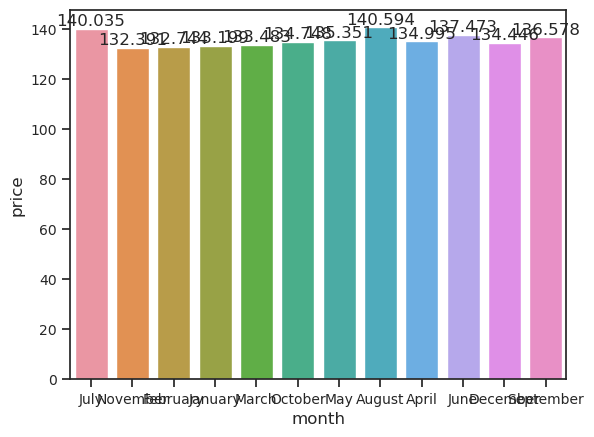

In [316]:
df_quest_5 = ps.read_csv('plots/df_quest_5').to_pandas()

ax = sns.barplot(data=df_quest_5, x='month', y='price')

for i in ax.containers:
    ax.bar_label(i,)


### 6. Does day of week affect the prices? When is the best time to book?

In [258]:
df_quest_6 = (df_calendar.groupby('dayofweek')
                         .mean()
                         .reset_index())

df_quest_6.to_csv('plots/df_quest_6', index=False)


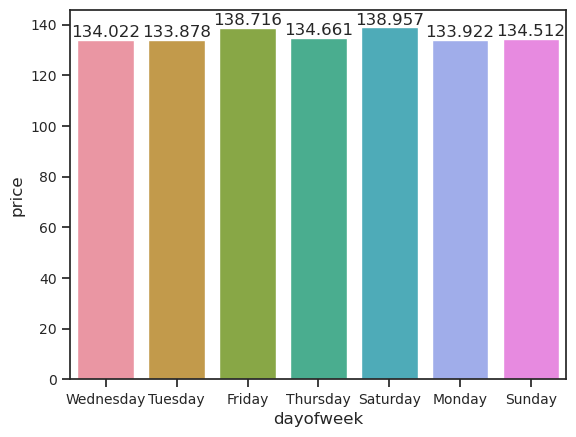

In [317]:
df_quest_6 = ps.read_csv('plots/df_quest_6').to_pandas()

ax = sns.barplot(data=df_quest_6, x='dayofweek', y='price')

for i in ax.containers:
    ax.bar_label(i,)


### 7. What month is more in "demand"?

In [260]:
df_quest_7 = (df_calendar.assign(count=1)
                         .loc[df_calendar['available'] == 'f']
                         .groupby('month')
                         .count()
                         .reset_index())

df_quest_7.to_csv('plots/df_quest_7', index=False)


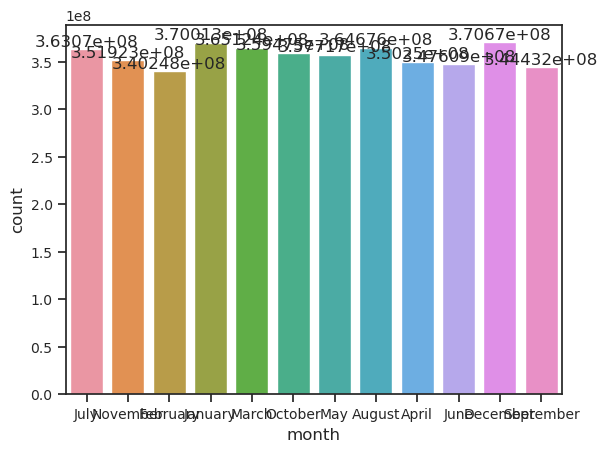

In [318]:
df_quest_7 = ps.read_csv('plots/df_quest_7').to_pandas()

ax = sns.barplot(data=df_quest_7, x='month', y='count')

for i in ax.containers:
    ax.bar_label(i,)


### 8. What day of week is more in "demand"?

In [262]:
df_quest_8 = (df_calendar.assign(count=1)
                         .loc[df_calendar['available'] == 'f']
                         .groupby('dayofweek')
                         .count()
                         .reset_index())

df_quest_8.to_csv('plots/df_quest_8', index=False)

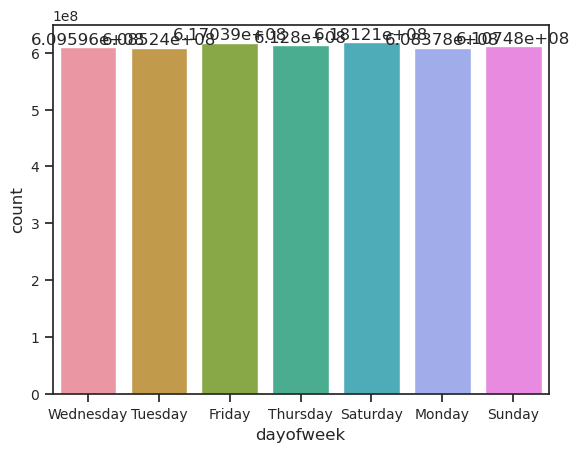

In [319]:
df_quest_8 = ps.read_csv('plots/df_quest_8').to_pandas()

ax = sns.barplot(data=df_quest_8, x='dayofweek', y='count')

for i in ax.containers:
    ax.bar_label(i,)


### 9. Can we group the listings based on prices and popularity?

In [264]:
df_quest_9 = (df_calendar.assign(term=df_calendar['minimum_nights'] <= 7)
                         .groupby('term')
                         .mean()
                         .rename(index={True:'Short', False: 'Long'})
                         .reset_index())

df_quest_9.to_csv('plots/df_quest_9', index=False)

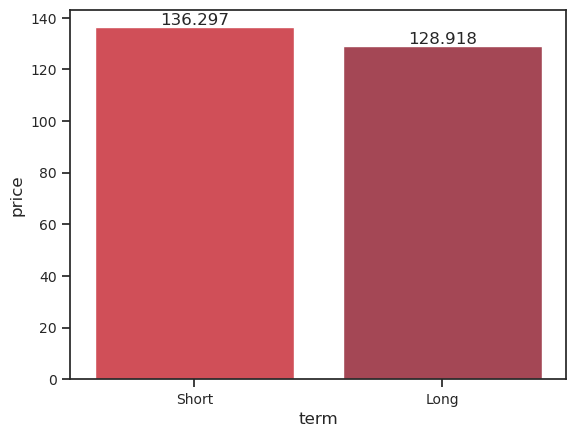

In [320]:
df_quest_9 = ps.read_csv('plots/df_quest_9').to_pandas()

ax = sns.barplot(data=df_quest_9, x='term', y='price')

for i in ax.containers:
    ax.bar_label(i,)


## Cross-country Comparative Analysis

### 10. How does the price differ per country? Are there any notable differences?

In [266]:
df_quest_10 = (df_calendar.groupby('country')
                          .mean()
                          .reset_index())

df_quest_10.to_csv('plots/df_quest_10', index=False)

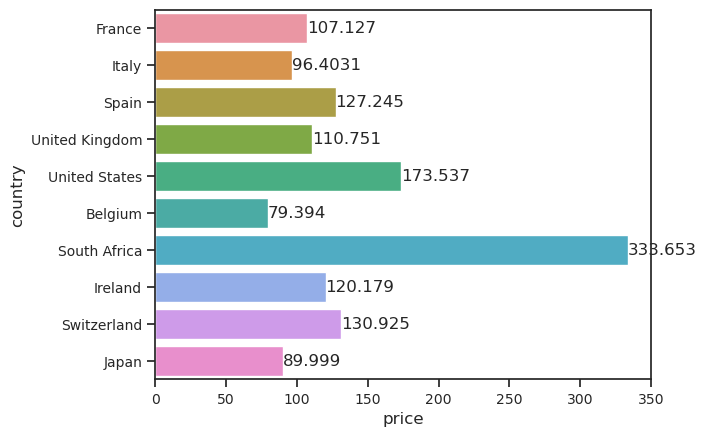

In [321]:
df_quest_10 = ps.read_csv('plots/df_quest_10').to_pandas()

ax = sns.barplot(data=df_quest_10, x='price', y='country')

for i in ax.containers:
    ax.bar_label(i,)


### 11. How does the demand differ per country?

In [268]:
df_quest_11 = (df_calendar.assign(count=1)
                          .loc[df_calendar['available'] == 'f']
                          .groupby('country')
                          .count()
                          .reset_index())
               
df_quest_11.to_csv('plots/df_quest_11', index=False)


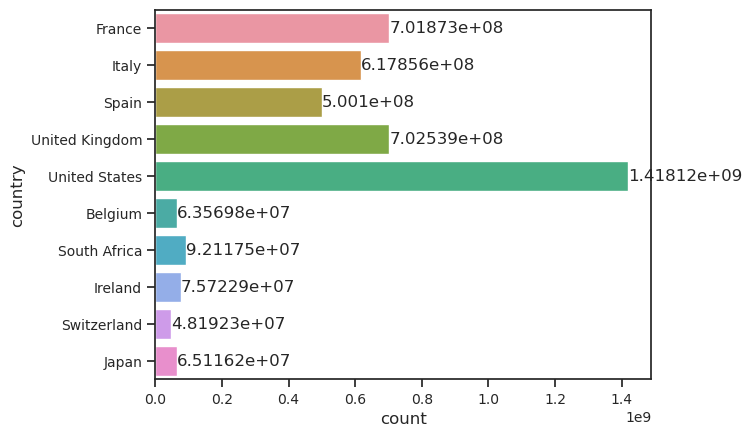

In [322]:
df_quest_11 = ps.read_csv('plots/df_quest_11').to_pandas()

ax = sns.barplot(data=df_quest_11, x='count', y='country')

for i in ax.containers:
    ax.bar_label(i,)


### 12. How does the supply differ per country?

In [270]:
df_quest_12 = (df_calendar.assign(count=1)
                          .groupby('country')
                          .count()
                          .reset_index())

df_quest_12.to_csv('plots/df_quest_12', index=False)


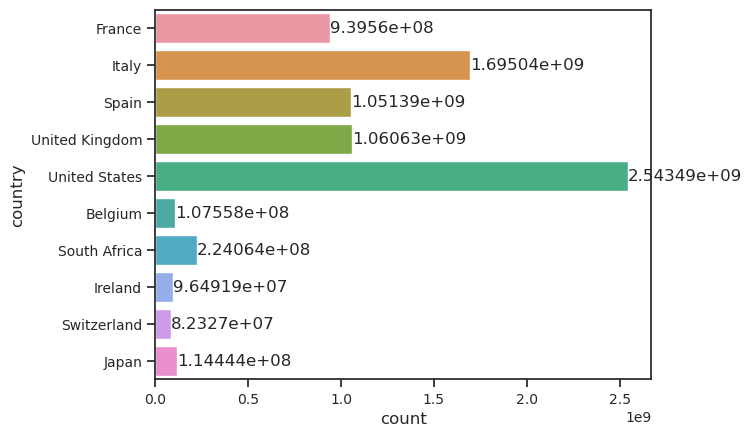

In [323]:
df_quest_12 = ps.read_csv('plots/df_quest_12').to_pandas()

ax = sns.barplot(data=df_quest_12, x='count', y='country')

for i in ax.containers:
    ax.bar_label(i,)


### 13. Which countries prefer short- vs. long-term stay?

In [273]:
df_quest_13 = ((df_calendar.assign(preference=df_calendar['minimum_nights'] <= 7)
                           .set_index('preference')
                           .rename(index={True:1, False: 0})
                           .reset_index()
                           .groupby('country')
                           .sum()
                           ['preference'] > (data_shape[0]/2))
                               .reset_index()
                               .set_index('preference')
                               .rename(index={True: 'Short-Term',
                                              False: 'Long-Term'})
                               .reset_index()[['country', 'preference']])

df_quest_13.to_csv('plots/df_quest_13', index=False)

In [324]:
df_quest_13 = ps.read_csv('plots/df_quest_13').to_pandas()
display(df_quest_13)

,country,preference
0,France,Long-Term
1,Italy,Long-Term
2,Spain,Long-Term
3,United Kingdom,Long-Term
4,United States,Long-Term
5,Belgium,Long-Term
6,South Africa,Long-Term
7,Ireland,Long-Term
8,Switzerland,Long-Term
9,Japan,Long-Term


-End of Query Notebook-